# Лабораторная работа №4

<ipython-input-14-3080a3728ffa>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_class_a, y='customerid', x='total_revenue', palette=custom_palette)
<ipython-input-14-3080a3728ffa>:119: UserWarning: 
The palette list has fewer values (10) than needed (72) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df_class_a, y='customerid', x='total_revenue', palette=custom_palette)


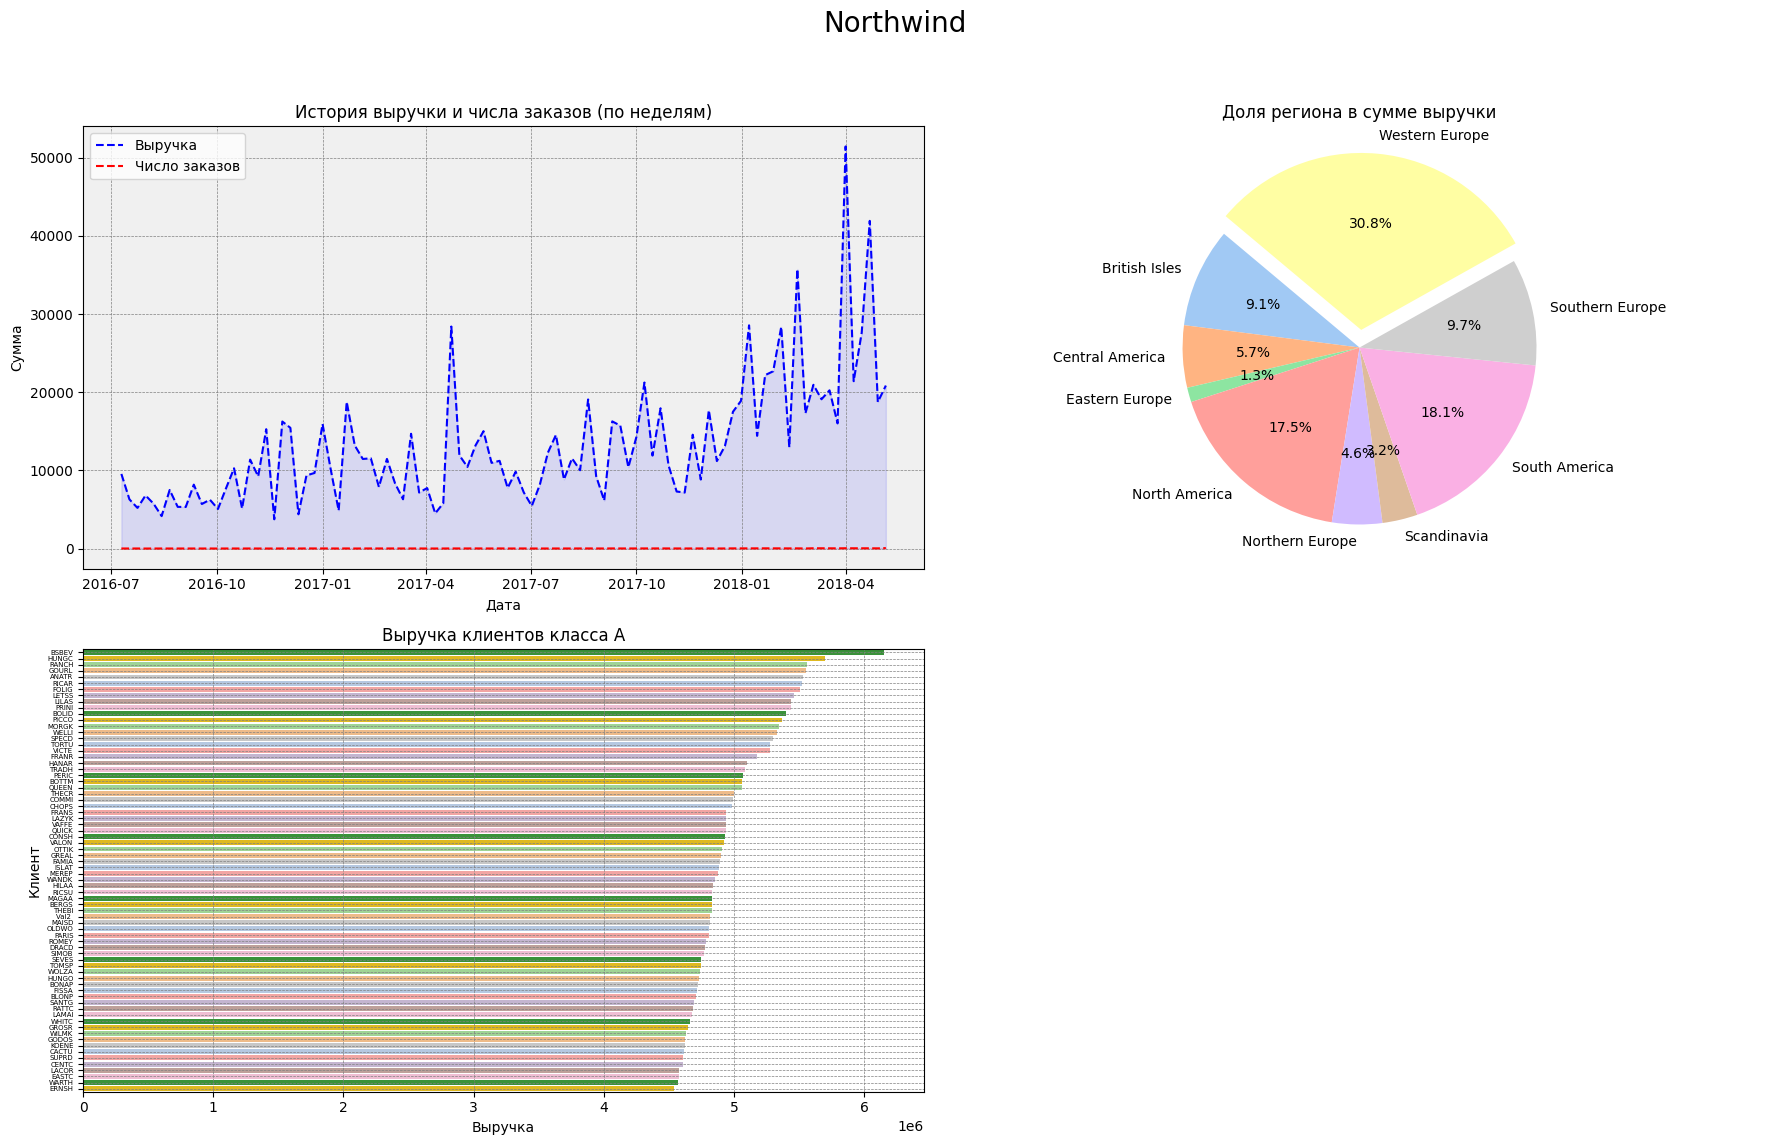

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

con = sqlite3.Connection('/content/northwind.db')

query = '''
WITH revenues AS (
    SELECT
        orders.shipregion,
        orders.customerid,
        orders.orderid,
        orders.orderdate,
        "order details".productid,
        ("order details".unitprice * "order details".quantity * (1 - "order details".discount)) AS revenue
    FROM orders
    JOIN "order details" ON orders.orderid = "order details".orderid
    GROUP BY orders.orderdate, orders.shipregion, orders.customerid, orders.orderid, "order details".productid
)
SELECT
    orderdate,
    shipregion,
    customerid,
    SUM(revenue) AS revenuedaily,
    COUNT(orderid) AS ordersdaily
FROM revenues
GROUP BY orderdate;
'''

df = pd.read_sql(query, con=con)

con.close()

df['orderdate'] = pd.to_datetime(df['orderdate'], format='%Y-%m-%d', errors='coerce')
df.set_index('orderdate', inplace=True)

# 2.1. Создание линейных графиков для выручки и числа заказов (суммарно за неделю)
weekly_data = df.resample('W').agg({
    'revenuedaily': 'sum',
    'ordersdaily': 'sum'
}).reset_index()

# 2.2. Подготовка данных для круговой диаграммы (доля региона в сумме выручки)
con = sqlite3.Connection('/content/northwind.db')
query_region = '''
WITH revenues AS (
    SELECT
        orders.shipregion,
        "order details".unitprice,
        "order details".quantity,
        "order details".discount
    FROM orders
    JOIN "order details" ON orders.orderid = "order details".orderid
)
SELECT
    shipregion,
    SUM(unitprice * quantity * (1 - discount)) AS total_revenue
FROM revenues
GROUP BY shipregion;
'''
df_region = pd.read_sql(query_region, con=con)
con.close()

# 2.3. Подготовка данных для столбчатой диаграммы (выручка клиентов класса A)
con = sqlite3.Connection('/content/northwind.db')
query_customers = '''
WITH revenues AS (
    SELECT
        orders.customerid,
        "order details".unitprice,
        "order details".quantity,
        "order details".discount
    FROM orders
    JOIN "order details" ON orders.orderid = "order details".orderid
)
SELECT
    customerid,
    SUM(unitprice * quantity * (1 - discount)) AS total_revenue
FROM revenues
GROUP BY customerid
ORDER BY total_revenue DESC;
'''
df_customers = pd.read_sql(query_customers, con=con)
con.close()

df_customers['cumulative_revenue'] = df_customers['total_revenue'].cumsum()
total_revenue = df_customers['total_revenue'].sum()
df_customers['cumulative_percent'] = 100 * df_customers['cumulative_revenue'] / total_revenue
df_class_a = df_customers[df_customers['cumulative_percent'] <= 80]

plt.figure(figsize=(18, 12))

# 2.1. Линейные графики выручки и заказов
ax1 = plt.subplot(2, 2, 1)
sns.lineplot(data=weekly_data, x='orderdate', y='revenuedaily', label='Выручка', linestyle='--', color='blue')
sns.lineplot(data=weekly_data, x='orderdate', y='ordersdaily', label='Число заказов', linestyle='--', color='red')
ax1.fill_between(weekly_data['orderdate'], weekly_data['revenuedaily'], color='blue', alpha=0.1)
ax1.fill_between(weekly_data['orderdate'], weekly_data['ordersdaily'], color='red', alpha=0.1)
ax1.set_title('История выручки и числа заказов (по неделям)')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Сумма')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')

# 2.2. Круговая диаграмма доли региона в выручке
ax2 = plt.subplot(2, 2, 2)
max_region = df_region.loc[df_region['total_revenue'].idxmax(), 'shipregion']
explode = [0.1 if region == max_region else 0 for region in df_region['shipregion']]
colors = sns.color_palette('pastel')[0:len(df_region)]
sns.set_palette('pastel')
ax2.pie(df_region['total_revenue'], labels=df_region['shipregion'], autopct='%1.1f%%',
        startangle=140, explode=explode, colors=colors)
ax2.set_title('Доля региона в сумме выручки')

# 2.3. Столбчатая диаграмма выручки клиентов класса A
ax3 = plt.subplot(2, 2, 3)
custom_palette = sns.color_palette(["#2ca02c", "#ffcc00", "#98df8a", "#ffbb78", "#c7c7c7", "#aec7e8", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2"])
sns.barplot(data=df_class_a, y='customerid', x='total_revenue', palette=custom_palette)
ax3.set_title('Выручка клиентов класса A')
ax3.set_ylabel('Клиент')
ax3.set_xlabel('Выручка')
plt.setp(ax3.get_yticklabels(), fontsize=5)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')

# 2.4. Пустой график или дополнительный график по вашему выбору
ax4 = plt.subplot(2, 2, 4)
ax4.axis('off')

plt.suptitle('Northwind', fontsize=20)

ax1.set_facecolor('#f0f0f0')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
